In [126]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def neighbors(iterable):
    iterable=iter(iterable)
    prev=None
    cur=iterable.next()
    for nxt in iterable:
        yield prev,cur,nxt
        prev,cur=cur,nxt
    nxt=None
    yield prev,cur,nxt    

In [3]:
def test_neighbors():
    test_neighbors = neighbors( range(2) )
    assert test_neighbors.next() == (None, 0, 1)

test_neighbors()

In [4]:
df = pd.read_csv("dataset.csv", parse_dates=["dttm"])
df.sort_values('dttm')
df['chaffeur_info']=zip(df['status'],df['dttm'])
df=df.drop(['status','dttm'],axis=1)
df=df.groupby('chaffeur_id', as_index=False)['chaffeur_info'].agg({'chaffeur_info':(lambda x: list(x))})

In [5]:
def calc_status_duration(chaffeur_info):
    chaffeur_info_updated = []    
    for i, j, k in neighbors(chaffeur_info):
        if i is not None: chaffeur_info_updated.append((i[0],i[1],(j[1]-i[1]).total_seconds()))
        if k is None: chaffeur_info_updated.append((j[0],j[1],None))
    return chaffeur_info_updated

In [6]:
def test_calc_status_duration():
    sample_chaffeur_info = [("free", datetime(2018, 4, 2, 0, 19)), 
                          ("busy", datetime(2018, 4, 2, 1, 3)),]
    sample_chaffeur_info_updated = [('free', datetime(2018, 4, 2, 0, 19), 2640.0),
                                  ('busy', datetime(2018, 4, 2, 1, 3), None),]
    assert calc_status_duration(sample_chaffeur_info) == sample_chaffeur_info_updated

test_calc_status_duration()

In [7]:
df["chaffeur_info"] = df.chaffeur_info.apply(calc_status_duration)

In [8]:
TIMEOUT = 1600

def collapse_statuses(chaffeur_info):
    # Here define conditions under which the "free" state 
    # should be attributed to the trip.
    # ... type your code here ...
    chaffeur_info_updated=[]
    free=0
    busyOrEnroute=["busy","enroute"]
    for i,j,k in neighbors(chaffeur_info):
        if k is not None:
            if(j[0]=="free"):
                if(j[2] is not None):free+=j[2]
                continue
            if(j[0] in busyOrEnroute):
                if(k[0]=="free" and j[2]>=TIMEOUT):
                    free=0
                    continue
            if(j[0]=="ontrip"):
                eff=(j[2],j[2]/(j[2]+i[2]+free))
                chaffeur_info_updated.append(eff)
                free=0
    return chaffeur_info_updated

In [9]:
def test_collapse_statuses():
    sample_chaffeur_info = [("free", datetime(2018, 4, 2, 0, 19), 2640.0), 
                          ("busy", datetime(2018, 4, 2, 1, 3), 1660.0),
                          ("free", datetime(2018, 4, 2, 1, 30, 40), 2050.0),
                          ("enroute", datetime(2018, 4, 2, 2, 4, 50), 70.0),
                          ("free", datetime(2018, 4, 2, 2, 6), 500.0),
                          ("enroute", datetime(2018, 4, 2, 2, 14, 20), 520.0),
                          ("ontrip", datetime(2018, 4, 2, 2, 23), 3060.0),
                          ("free", datetime(2018, 4, 2, 3, 14), None)
                         ]
    sample_chaffeur_info_updated = [(3060.0, 3060.0 / (3060.0 + 520.0 + 500.0 + 2050.0))]
    assert collapse_statuses(sample_chaffeur_info) == sample_chaffeur_info_updated

test_collapse_statuses()

In [10]:
df["chaffeur_info"] = df.chaffeur_info.apply(collapse_statuses)

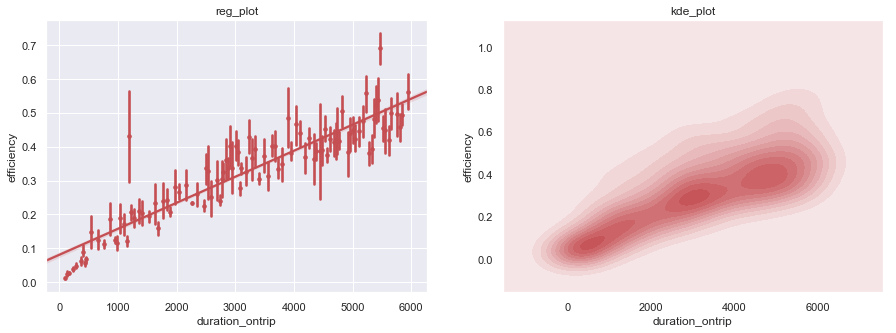

In [354]:
df2=df.drop(labels='chaffeur_id',axis=1)
listOfTuples=[]
for f in df2['chaffeur_info']:
    for t in f:
        listOfTuples.append(t)

df3=pd.DataFrame(listOfTuples, columns=['duration_ontrip','efficiency']).sort_values('duration_ontrip').reset_index(drop=True)
x=df3['duration_ontrip']; y=df3['efficiency']


fig,(ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(15,5))

ax1.set_title("reg_plot")
ax2.set_title("kde_plot")

# plt.figure(figsize=(10,5))
# sns.set(style="darkgrid")
sns.regplot(x,y,marker='.',ci=68, color='r',x_bins=100,ax=ax1)
sns.kdeplot(x,y,ax=ax2,shade=True,color='r')

